In [1]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.DiGraph(nx.erdos_renyi_graph(10, 0.5))
#We personalize it for node 0
personalization_dict = {id:0 for id in G.nodes()}
personalization_dict[0] = 1
pr = nx.pagerank(G)
pr = nx.pagerank(G, alpha=0.85, personalization=personalization_dict)

In [7]:
#Here we obtain the node2vec embedding of a graph
from node2vec import Node2Vec
import networkx as nx
G = nx.erdos_renyi_graph(100, 0.5)
node2vec = Node2Vec(G, seed=128)
model = node2vec.fit(seed=129)

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 40.66it/s]


In [1]:
from modules.random_graph import LFRBenchmark

#We can generate a graph with the LFR benchmark
n = 400
homophily = 0.95
modularity = 0.05

lfr1 = LFRBenchmark(n, homophily=0.80, modularity=0.05, init_opinions=True)
lfr2 = LFRBenchmark(n, homophily=0.20, modularity=0.05, init_opinions=True)
lfr3 = LFRBenchmark(n, homophily=0.80, modularity=0.95, init_opinions=True)
lfr4 = LFRBenchmark(n, homophily=0.20, modularity=0.95, init_opinions=True)


In [2]:
lfr1_net = lfr1.G
lfr2_net = lfr2.G
lfr3_net = lfr3.G
lfr4_net = lfr4.G

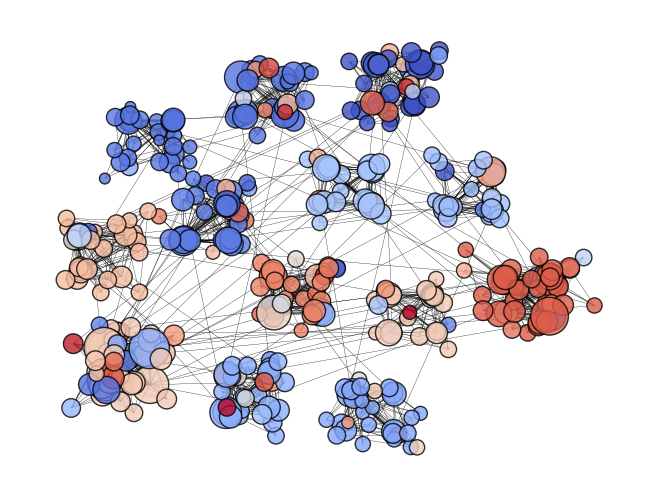

In [3]:
lfr1.plot_graph()

In [7]:
lfr1_net.out_degree()

OutDegreeView({0: 13, 1: 6, 2: 6, 3: 9, 4: 15, 5: 9, 6: 15, 7: 8, 8: 13, 9: 36, 10: 6, 11: 7, 12: 17, 13: 10, 14: 9, 15: 14, 16: 23, 17: 9, 18: 9, 19: 8, 20: 10, 21: 10, 22: 18, 23: 12, 24: 5, 25: 6, 26: 12, 27: 12, 28: 6, 29: 10, 30: 10, 31: 11, 32: 13, 33: 10, 34: 11, 35: 10, 36: 9, 37: 13, 38: 18, 39: 27, 40: 9, 41: 9, 42: 11, 43: 6, 44: 8, 45: 6, 46: 8, 47: 8, 48: 9, 49: 10, 50: 8, 51: 9, 52: 13, 53: 8, 54: 3, 55: 7, 56: 8, 57: 13, 58: 6, 59: 9, 60: 16, 61: 7, 62: 9, 63: 9, 64: 10, 65: 6, 66: 14, 67: 7, 68: 16, 69: 14, 70: 19, 71: 9, 72: 14, 73: 9, 74: 12, 75: 7, 76: 6, 77: 7, 78: 7, 79: 13, 80: 5, 81: 24, 82: 8, 83: 9, 84: 8, 85: 7, 86: 8, 87: 10, 88: 8, 89: 5, 90: 7, 91: 8, 92: 7, 93: 8, 94: 8, 95: 9, 96: 41, 97: 13, 98: 7, 99: 11, 100: 7, 101: 7, 102: 14, 103: 8, 104: 9, 105: 4, 106: 5, 107: 7, 108: 10, 109: 5, 110: 12, 111: 6, 112: 7, 113: 9, 114: 7, 115: 6, 116: 8, 117: 8, 118: 6, 119: 10, 120: 6, 121: 7, 122: 11, 123: 20, 124: 8, 125: 15, 126: 6, 127: 9, 128: 36, 129: 6, 130:

In [4]:
def create_pos_from_communities(node2community, g, seed=42):
    np.random.seed(seed)

    # Determine the number of communities
    numb_communities = len(node2community)
    
    # Count the number of nodes in each community
    community2count = {k: len(v) for k, v in node2community.items()}
    
    # Determine the number of communities
    #numb_communities = max(node2community) + 1
    
    # Count the number of nodes in each community
    #community2count = collections.Counter(node2community)
    
    # Initialize the distance matrix
    A = np.zeros((numb_communities, numb_communities))
    
    # Fill the distance matrix with values inversely proportional to the community sizes
    for u in range(numb_communities):
        for v in range(numb_communities):
            A[u, v] = 100 / (5 * (community2count[u] + community2count[v]))

    # Create a graph from the distance matrix
    G_centroids = nx.from_numpy_matrix(A)
    
    # Compute the positions for the community centroids using spring layout
    pos_centroids = nx.spring_layout(G_centroids, weight='weight', seed=seed)
    # Initialize a dictionary to store positions of nodes
    pos = {}
    
    # Assign positions to nodes within their respective communities
    for centroid in G_centroids.nodes():
        centr_pos = pos_centroids[centroid]
        nodes_in_community = node2community[centroid]
        #nodes_in_community = np.where(node2community == centroid)[0]
        
        # Sort nodes by their degree in descending order
        sorted_nodes = sorted(nodes_in_community, key=lambda x: g.degree[x], reverse=True)
        
        for i, node in enumerate(sorted_nodes):
            # Place nodes near their community centroid with a small random offset
            offset = .2 * i * np.random.uniform(low=-.025, high=.025, size=2)
            additional_offset = np.array([np.random.choice([-0.1, 0.1]), np.random.choice([-0.1, 0.1])])
            pos[node] = centr_pos + offset + additional_offset
    
    return pos

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import collections

def plot_graph(network: nx.DiGraph, seed: int = 80, ax: plt.Axes = None):
    graph = network.G
    pos = create_pos_from_communities(network.labeled_communities, graph)
    color = [graph.nodes[n]["opinion"] for n in graph.nodes]
    size = [graph.degree[n]*10 for n in graph.nodes]
    nx.draw(graph, pos, node_color=color, node_size=size, with_labels=False,
            alpha=0.8, width=0.15, edgecolors="k", cmap="coolwarm", ax=ax)
    ax.axis("on")

Text(0.5, 0, '$\\eta = 0.20$')

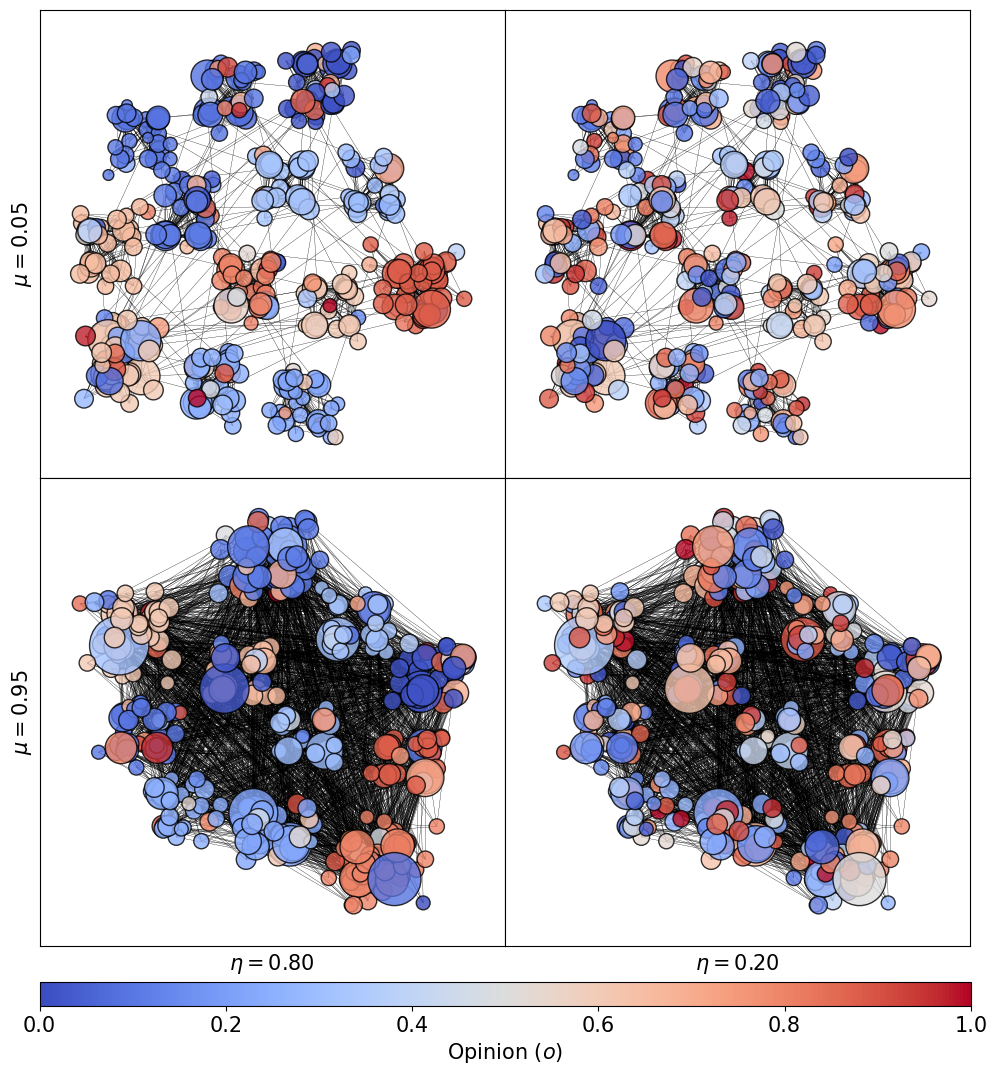

In [5]:
#Here we plot the graph and color by opinion, size proportional to degree, fruchterman_reingold layout
import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
lfr1.plot_graph(ax=axs[0, 0])
lfr2.plot_graph(ax=axs[0, 1])
lfr3.plot_graph(ax=axs[1, 0])
lfr4.plot_graph(ax=axs[1, 1])
#Here we add a colorbar at the bottom for all the plots that spans the width of the figure
fig.subplots_adjust(bottom=0.1,
                    wspace=0,
                    hspace=0)
cbar_ax = fig.add_axes([0.125, 0.05, 0.776, 0.02])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=1),cmap="coolwarm"),cax=cbar_ax,orientation="horizontal")
cb.set_label("Opinion $(o)$", size=15)
cb.ax.tick_params(labelsize=15)
axs[0,0].set_ylabel("$\mu = 0.05$", size=15)
axs[1,0].set_ylabel("$\mu = 0.95$", size=15)
axs[1,0].set_xlabel("$\eta = 0.80$", size=15)
axs[1,1].set_xlabel("$\eta = 0.20$", size=15)
#plt.savefig("lfr_benchmark.png", dpi = 300, bbox_inches='tight')

In [6]:
lfr1_net.degree()

DegreeView({0: 13, 1: 6, 2: 6, 3: 9, 4: 15, 5: 9, 6: 15, 7: 8, 8: 13, 9: 38, 10: 6, 11: 7, 12: 17, 13: 10, 14: 9, 15: 14, 16: 25, 17: 9, 18: 9, 19: 8, 20: 10, 21: 10, 22: 18, 23: 12, 24: 5, 25: 6, 26: 12, 27: 12, 28: 6, 29: 10, 30: 10, 31: 11, 32: 13, 33: 10, 34: 11, 35: 10, 36: 9, 37: 13, 38: 18, 39: 29, 40: 11, 41: 9, 42: 11, 43: 6, 44: 8, 45: 6, 46: 8, 47: 8, 48: 9, 49: 10, 50: 8, 51: 9, 52: 13, 53: 8, 54: 5, 55: 7, 56: 8, 57: 13, 58: 6, 59: 9, 60: 16, 61: 7, 62: 9, 63: 9, 64: 10, 65: 6, 66: 14, 67: 7, 68: 16, 69: 16, 70: 19, 71: 9, 72: 14, 73: 9, 74: 12, 75: 7, 76: 8, 77: 7, 78: 7, 79: 13, 80: 7, 81: 24, 82: 8, 83: 9, 84: 8, 85: 7, 86: 10, 87: 10, 88: 10, 89: 5, 90: 7, 91: 8, 92: 7, 93: 8, 94: 10, 95: 9, 96: 43, 97: 13, 98: 7, 99: 11, 100: 7, 101: 7, 102: 16, 103: 8, 104: 9, 105: 6, 106: 5, 107: 7, 108: 10, 109: 5, 110: 12, 111: 6, 112: 9, 113: 9, 114: 7, 115: 6, 116: 8, 117: 8, 118: 6, 119: 10, 120: 6, 121: 7, 122: 11, 123: 22, 124: 8, 125: 15, 126: 6, 127: 9, 128: 38, 129: 6, 130

In [5]:
from collections import Counter
from scipy.optimize import curve_fit
import numpy as np
degree_distribution = dict(lfr1_net.in_degree())
#Here we obtain the x and y values of the degree distribution using the Counter method from the collections library
counter_dict = Counter(degree_distribution.values())
x = np.array(list(counter_dict.keys()))
y = np.array(list(counter_dict.values()))/lfr1_net.number_of_nodes()

In [6]:
#Here we fit a power law to the degree distribution using the curve_fit method from scipy
#First we define the power law function
def power_law(x, a, b):
    return a*x**b
#Here we fit the power law to the degree distribution
popt, pcov = curve_fit(power_law, x, y)

In [11]:
pcov

array([[ 0.00610513, -0.01977988],
       [-0.01977988,  0.07136117]])

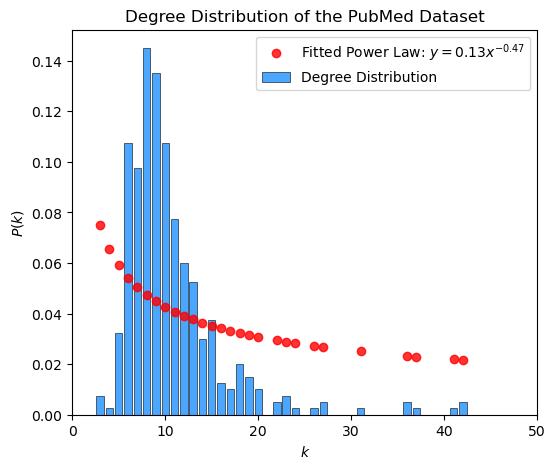

In [15]:
import matplotlib.pyplot as plt
#Now we plot the degree distribution and the fitted power law
plt.figure(figsize=(6, 5))
plt.bar(x, y,  color='dodgerblue', alpha=0.8, edgecolor='black', linewidth=0.5, width=0.8, label='Degree Distribution')
plt.plot(x, power_law(x, *popt), 'o', color='red', alpha=0.8, label=f'Fitted Power Law: $y = {round(popt[0],2)}x^{{{round(popt[1],2)}}}$')
plt.xlim(0, 50)
plt.xlabel('$k$')
plt.ylabel('$P(k)$')
plt.title('Degree Distribution of the PubMed Dataset')
plt.legend()
#plt.savefig('plots/degree_distribution_pubmed_pl.png', dpi=300, bbox_inches='tight')